In [5]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
NEON_CONNECTION_STRING = os.getenv("NEON_CONNECTION_STRING")

# Create SQLAlchemy engine
engine = create_engine(NEON_CONNECTION_STRING)

print("✅ Connected to Neon database")

✅ Connected to Neon database


In [6]:
query_monthly_sales = """
SELECT 
    DATE_TRUNC('month', "InvoiceDate"::timestamp) AS month,
    SUM("TotalPrice") AS total_sales
FROM sales_data
GROUP BY 1
ORDER BY 1;
"""
monthly_sales = pd.read_sql(query_monthly_sales, engine)
monthly_sales.head()

,month,total_sales
0,2010-12-01,570422.730
1,2011-01-01,568101.310
2,2011-02-01,446084.920
3,2011-03-01,594081.760
4,2011-04-01,468374.331


In [7]:
df_forecast = monthly_sales.rename(columns={'month': 'ds', 'total_sales': 'y'})
df_forecast['ds'] = pd.to_datetime(df_forecast['ds'])

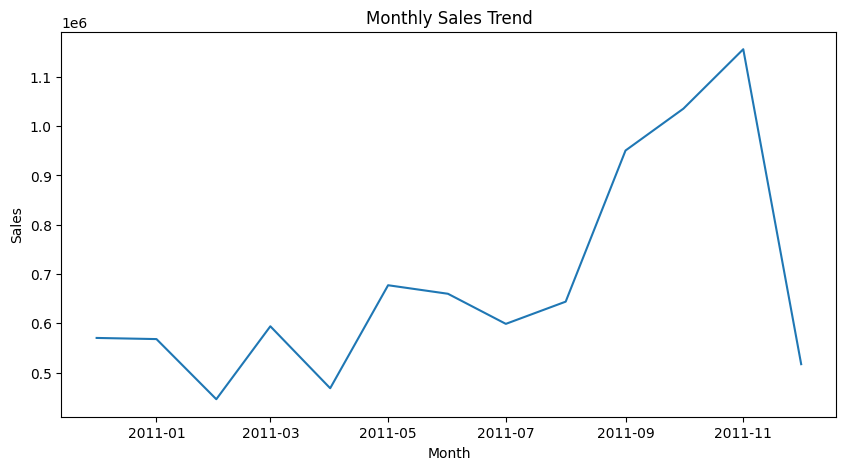

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_forecast['ds'], df_forecast['y'])
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()

In [9]:
df_forecast = monthly_sales.rename(columns={'month': 'ds', 'total_sales': 'y'})
df_forecast['ds'] = pd.to_datetime(df_forecast['ds'])
df_forecast = df_forecast.sort_values('ds')
df_forecast.tail()

,ds,y
8,2011-08-01,644051.040
9,2011-09-01,950690.202
10,2011-10-01,1035642.450
11,2011-11-01,1156205.610
12,2011-12-01,517190.440


In [10]:
from prophet import Prophet

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Using Prophet Model because
It works well for monthly e-commerce sales.

It’s easy to explain and visualize.

It shows business insights (seasonality, growth).

You can easily deploy it later via Streamlit for interactive forecasting.

In [11]:
model = Prophet()
model.fit(df_forecast)

20:37:43 - cmdstanpy - INFO - Chain [1] start processing
20:37:43 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
future = model.make_future_dataframe(periods=3, freq='MS', include_history=True)
forecast = model.predict(future)

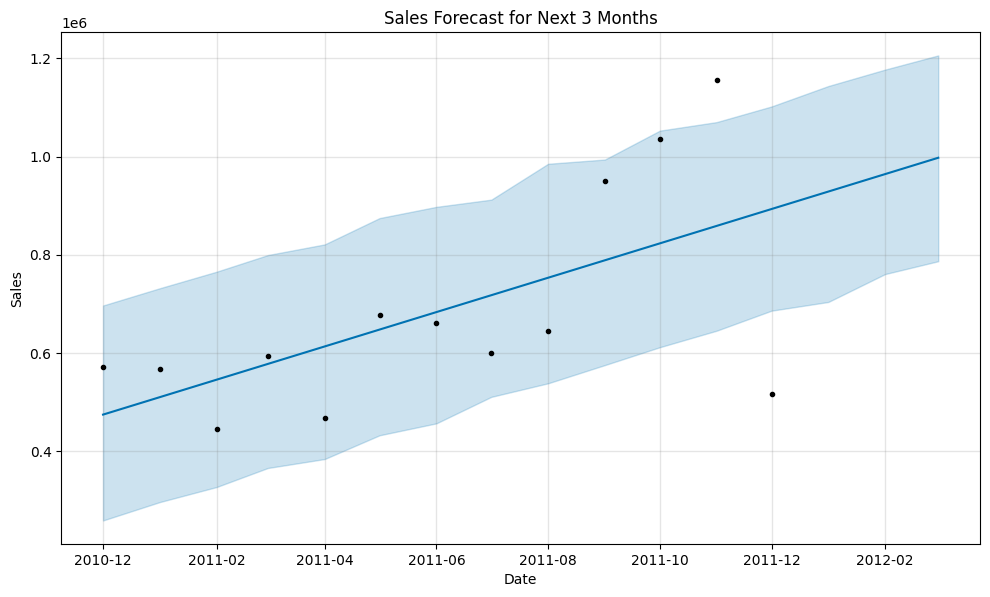

In [13]:
model.plot(forecast)
plt.title("Sales Forecast for Next 3 Months")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

In [14]:
# show date ranges
print("df_forecast (input) range:", df_forecast['ds'].min(), "→", df_forecast['ds'].max())
print("future range:", future['ds'].min(), "→", future['ds'].max())
print("forecast range (ds):", forecast['ds'].min(), "→", forecast['ds'].max())

# see last rows of `forecast` to inspect future predictions
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(20)

df_forecast (input) range: 2010-12-01 00:00:00 → 2011-12-01 00:00:00
future range: 2010-12-01 00:00:00 → 2012-03-01 00:00:00
forecast range (ds): 2010-12-01 00:00:00 → 2012-03-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper
0,2010-12-01,474389.080613,258807.438464,6.965916e+05
1,2011-01-01,509947.908940,296246.694443,7.317561e+05
2,2011-02-01,545506.737271,326886.965337,7.653888e+05
3,2011-03-01,577624.388665,365658.128002,7.992897e+05
4,2011-04-01,613183.216988,383895.434883,8.209850e+05
5,2011-05-01,647594.986327,432290.962739,8.746365e+05
6,2011-06-01,683153.814642,456562.582286,8.974643e+05
7,2011-07-01,717565.583973,510508.162931,9.121616e+05
8,2011-08-01,753124.412280,538153.676002,9.851878e+05
9,2011-09-01,788683.240578,575225.138293,9.938331e+05


In [15]:
print("Training data max date:", df_forecast['ds'].max())
print("Future df max date:", future['ds'].max())
print("Forecast df max date:", forecast['ds'].max())

Training data max date: 2011-12-01 00:00:00
Future df max date: 2012-03-01 00:00:00
Forecast df max date: 2012-03-01 00:00:00


In [16]:
# 1️⃣ Split into train & test (last 3 months for test)
train = df_forecast[:-3]   # everything except last 3
test = df_forecast[-3:]    # last 3 rows (Oct, Nov, Dec 2011)

print("Train range:", train['ds'].min(), "→", train['ds'].max())
print("Test range:", test['ds'].min(), "→", test['ds'].max())

# 2️⃣ Fit Prophet on TRAIN only
model = Prophet()
model.fit(train)

# 3️⃣ Build a 'future' df ONLY for existing dates (train + test)
future_hist = df_forecast[['ds']].copy()   # all original months

# 4️⃣ Get predictions for all historical dates
forecast_hist = model.predict(future_hist)

# 5️⃣ Merge test with forecast on 'ds'
pred_test = forecast_hist[['ds', 'yhat']].merge(test[['ds', 'y']], on='ds')

print(pred_test)

20:37:43 - cmdstanpy - INFO - Chain [1] start processing
20:37:43 - cmdstanpy - INFO - Chain [1] done processing


Train range: 2010-12-01 00:00:00 → 2011-09-01 00:00:00
Test range: 2011-10-01 00:00:00 → 2011-12-01 00:00:00
          ds           yhat           y
0 2011-10-01  790951.383329  1035642.45
1 2011-11-01  822955.737503  1156205.61
2 2011-12-01  853927.693156   517190.44


In [17]:
future = model.make_future_dataframe(periods=3, freq='MS', include_history=True)
forecast = model.predict(future)

In [18]:
print("Forecast date range:", forecast['ds'].min(), "→", forecast['ds'].max())
print("Test date range:", test['ds'].min(), "→", test['ds'].max())

Forecast date range: 2010-12-01 00:00:00 → 2011-12-01 00:00:00
Test date range: 2011-10-01 00:00:00 → 2011-12-01 00:00:00


In [19]:
forecast['month'] = forecast['ds'].dt.to_period('M').dt.to_timestamp()
test['month'] = test['ds'].dt.to_period('M').dt.to_timestamp()

/var/folders/zc/ljl3_lqn79125zg278rlpwtr0000gn/T/ipykernel_6268/2745533659.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['month'] = test['ds'].dt.to_period('M').dt.to_timestamp()


In [20]:
pred = pd.merge(
    test[['month', 'y']], 
    forecast[['month', 'yhat']], 
    on='month', 
    how='inner'  # only keep months present in both
)
print(pred)

       month           y           yhat
0 2011-10-01  1035642.45  790951.383329
1 2011-11-01  1156205.61  822955.737503
2 2011-12-01   517190.44  853927.693156


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(pred['y'], pred['yhat'])
rmse = np.sqrt(mean_squared_error(pred['y'], pred['yhat']))

print(f"📉 MAE: {mae:.2f}")
print(f"📈 RMSE: {rmse:.2f}")

📉 MAE: 304892.73
📈 RMSE: 307853.41


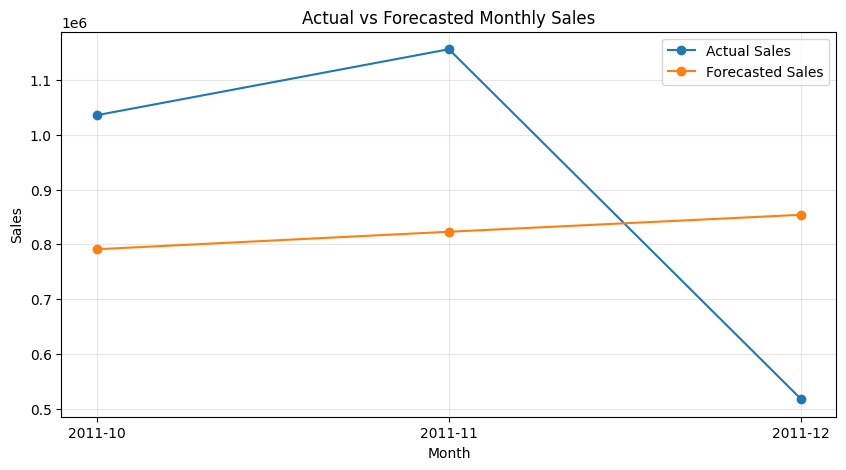

In [22]:
import matplotlib.pyplot as plt

# Convert timestamp to string month labels
pred['month_label'] = pred['month'].dt.strftime("%Y-%m")

plt.figure(figsize=(10,5))
plt.plot(pred['month_label'], pred['y'], marker='o', label='Actual Sales')
plt.plot(pred['month_label'], pred['yhat'], marker='o', label='Forecasted Sales')

plt.title('Actual vs Forecasted Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

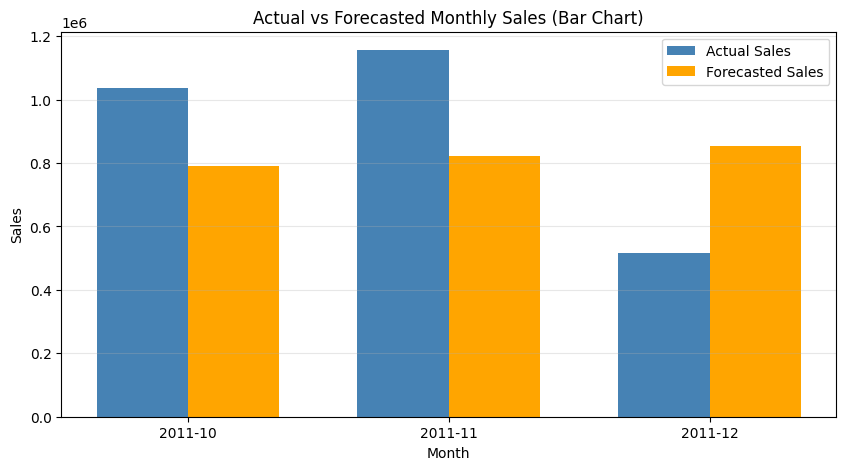

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Convert for clean x-axis labels
pred['month_label'] = pred['month'].dt.strftime("%Y-%m")

# Bar positions
x = np.arange(len(pred))  # [0,1,2]
width = 0.35  # width of each bar

plt.figure(figsize=(10,5))

# Bars
plt.bar(x - width/2, pred['y'], width, label='Actual Sales', color='steelblue')
plt.bar(x + width/2, pred['yhat'], width, label='Forecasted Sales', color='orange')

# Labels
plt.xticks(x, pred['month_label'])
plt.xlabel("Month")
plt.ylabel("Sales")
plt.title("Actual vs Forecasted Monthly Sales (Bar Chart)")
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.show()

In [26]:
import pandas as pd

# Load cleaned dataset
df = pd.read_csv("data/cleaned/ecommerce_cleaned.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

20:45:47 - cmdstanpy - INFO - Chain [1] start processing
20:45:47 - cmdstanpy - INFO - Chain [1] done processing
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


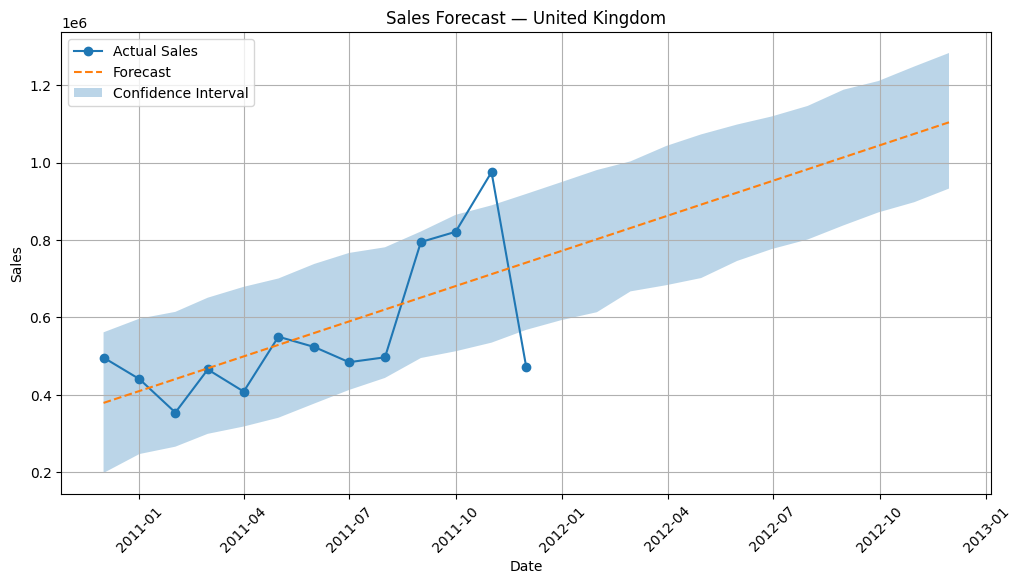

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
20,2012-07-31,9.827947e+05,801330.243856,1.146168e+06,9.827947e+05,9.827947e+05,0.0,0.0,0.0,0.0,0.0,0.0,9.827947e+05
21,2012-08-31,1.013558e+06,837881.085751,1.188123e+06,1.013558e+06,1.013558e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.013558e+06
22,2012-09-30,1.043328e+06,871238.208944,1.210433e+06,1.043328e+06,1.043328e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.043328e+06
23,2012-10-31,1.074091e+06,897633.040977,1.247942e+06,1.074091e+06,1.074091e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.074091e+06
24,2012-11-30,1.103862e+06,932766.594114,1.282843e+06,1.103862e+06,1.103862e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.103862e+06


In [28]:
# -----------------------------
# Multi-Series Forecasting
# -----------------------------

import matplotlib.pyplot as plt

# 1. Choose a country
country = "United Kingdom"  # You can change this to test
df_country = df[df["Country"] == country].copy()

# 2. Monthly aggregation
monthly = (
    df_country
        .groupby(df_country["InvoiceDate"].dt.to_period("M"))["TotalPrice"]
        .sum()
        .reset_index()
)

monthly["ds"] = monthly["InvoiceDate"].astype(str)
monthly.rename(columns={"TotalPrice": "y"}, inplace=True)

# 3. Fit Prophet model
model = Prophet()
model.fit(monthly[["ds", "y"]])

# 4. Forecast next 12 months
future = model.make_future_dataframe(periods=12, freq="M")
forecast = model.predict(future)

# 5. Plot actual vs forecast
# Convert to datetime to avoid matplotlib tz errors
forecast["ds"] = pd.to_datetime(forecast["ds"])
monthly["ds"] = pd.to_datetime(monthly["ds"])

# 5. Plot actual vs forecast
plt.figure(figsize=(12,6))
plt.plot(monthly["ds"], monthly["y"], label="Actual Sales", marker="o")
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast", linestyle="--")
plt.fill_between(
    forecast["ds"],
    forecast["yhat_lower"],
    forecast["yhat_upper"],
    alpha=0.3,
    label="Confidence Interval"
)

plt.title(f"Sales Forecast — {country}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

forecast.tail()